In [1]:
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
import numpy as np
from matplotlib import pyplot as plt
import math, os

In [2]:
z_dim = 3
usecuda = True
idgpu = 2
epochs = 40
kwargs = {}

In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=200, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False,download=True, transform=transforms.ToTensor()),
    batch_size=200, shuffle=True, **kwargs)

## Encoder and decoder use the DC-GAN architecture

### Encoder

In [4]:
class ChannelsToLinear(nn.Linear):
    """Flatten a Variable to 2d and apply Linear layer"""
    def forward(self, x):
        b = x.size(0)
        return super().forward(x.view(b,-1))
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        n_filters = 64
        self.conv1 = nn.Conv2d(1, n_filters, 4,2,1)
        self.conv2 = nn.Conv2d(n_filters, n_filters*2, 4, 2,1)
        
        self.toLinear1 =  ChannelsToLinear(n_filters*2*7*7, 1024)
        self.fc1 = nn.Linear(1024,z_dim)
        
        self.lrelu = nn.LeakyReLU(negative_slope=0.1)
        
    def forward(self,x):
        h1 = self.lrelu(self.conv1(x))
        h2 = self.lrelu(self.conv2(h1))
        h3 = self.lrelu(self.toLinear1(h2))
        h4 = self.fc1(h3)
        
        return h4
        
encodermodel = Encoder()
if usecuda:
    encodermodel.cuda(idgpu)       
        
        

### Decoder

In [5]:
class LinearToChannels2d(nn.Linear):
    """Reshape 2d Variable to 4d after Linear layer"""
    def __init__(self, m, n, w=1, h=None, **kw):
        h = h or w
        super().__init__(m, n*w*h, **kw)
        self.w = w
        self.h = h
    def forward(self, x):
        b = x.size(0)
        return super().forward(x).view(b, -1, self.w, self.h)
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        n_filters = 64
        
        self.fc1 = nn.Linear(z_dim,1024)
        self.LineartoChannel = LinearToChannels2d(1024,n_filters*2,7,7)
        self.conv1 = nn.ConvTranspose2d(n_filters*2,n_filters,4,2,1)
        self.conv2 = nn.ConvTranspose2d(n_filters,1,4,2,1)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,z):
        h1 = self.relu(self.fc1(z))
        h2 = self.relu(self.LineartoChannel(h1))
        
        h3 = self.relu(self.conv1(h2))
        h4 = self.sigmoid(self.conv2(h3))
        
        return h4
        
decodermodel = Decoder()
if usecuda:
    decodermodel.cuda(idgpu)    

## MMD Loss Function

In [6]:
def compute_kernel(x, y):
    x_size = x.shape[0]
    y_size = y.shape[0]
    dim = x.shape[1]

    tiled_x = x.view(x_size,1,dim).repeat(1, y_size,1)
    tiled_y = y.view(1,y_size,dim).repeat(x_size, 1,1)

    return torch.exp(-torch.mean((tiled_x - tiled_y)**2,dim=2)/dim*1.0)


def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    return torch.mean(x_kernel) + torch.mean(y_kernel) - 2*torch.mean(xy_kernel)

In [7]:
# Convert a numpy array of shape [batch_size, height, width, 1] into a displayable array 
# of shape [height*sqrt(batch_size, width*sqrt(batch_size))] by tiling the images
def convert_to_display(samples):
    cnt, height, width = int(math.floor(math.sqrt(samples.shape[0]))), samples.shape[1], samples.shape[2]
    samples = np.transpose(samples, axes=[1, 0, 2, 3])
    samples = np.reshape(samples, [height, cnt, cnt, width])
    samples = np.transpose(samples, axes=[1, 0, 2, 3])
    samples = np.reshape(samples, [height*cnt, width*cnt])
    return samples

In [10]:
plt.style.available

['seaborn-talk',
 'grayscale',
 'classic',
 'Solarize_Light2',
 'seaborn',
 'seaborn-colorblind',
 'ggplot',
 'fivethirtyeight',
 'seaborn-bright',
 'seaborn-ticks',
 'seaborn-pastel',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'bmh',
 'seaborn-white',
 'seaborn-paper',
 'fast',
 'tableau-colorblind10',
 'seaborn-poster',
 'dark_background',
 'seaborn-whitegrid',
 'seaborn-deep',
 '_classic_test',
 'seaborn-notebook',
 'seaborn-muted']

In [13]:
from mpl_toolkits.mplot3d import Axes3D

## Scatter Plot before training the VAE

<Figure size 640x480 with 0 Axes>

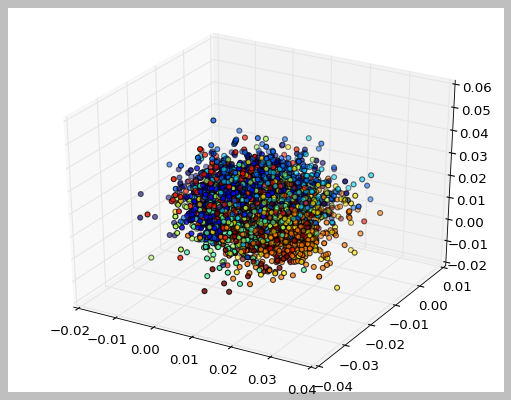

In [14]:
# If latent z is 2-dimensional we visualize it by plotting latent z of different digits in different colors
if z_dim == 3:
    z_list, label_list = [], []
    test_batch_size = 500
    #for i in range(20):
    i = 1
    for batch_idx, (test_x, test_y) in enumerate(test_loader):
        if(i>20):
            break
        test_x= Variable(test_x)
        if(usecuda):
            test_x = test_x.cuda(idgpu)
        z = encodermodel(test_x)   
        z_list.append(z.data.cpu())
        label_list.append(test_y)
        i = i+1
    z = np.concatenate(z_list, axis=0)
    label = np.concatenate(label_list)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
#     plt.style.use('_classic_test')
    ax.scatter(z[:, 0], z[:, 1],z[:, 2], c=label)
    plt.show()

## Training the VAE

Epoch 0 : Negative log likelihood is 0.235970, mmd loss is 0.081726
Epoch 0 : Negative log likelihood is 0.065659, mmd loss is 0.102950
Epoch 0 : Negative log likelihood is 0.062786, mmd loss is 0.032204


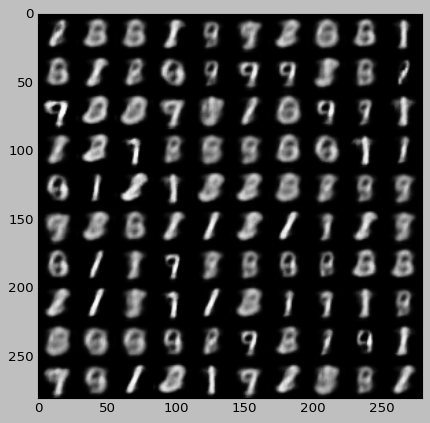

Epoch 1 : Negative log likelihood is 0.051228, mmd loss is 0.021162
Epoch 1 : Negative log likelihood is 0.047898, mmd loss is 0.017306
Epoch 1 : Negative log likelihood is 0.044497, mmd loss is 0.004762


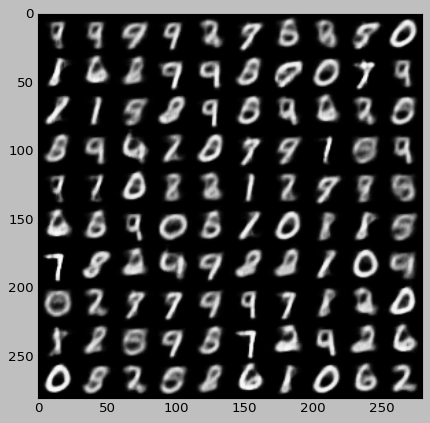

Epoch 2 : Negative log likelihood is 0.040200, mmd loss is 0.007511
Epoch 2 : Negative log likelihood is 0.040290, mmd loss is 0.004885
Epoch 2 : Negative log likelihood is 0.038767, mmd loss is 0.001673


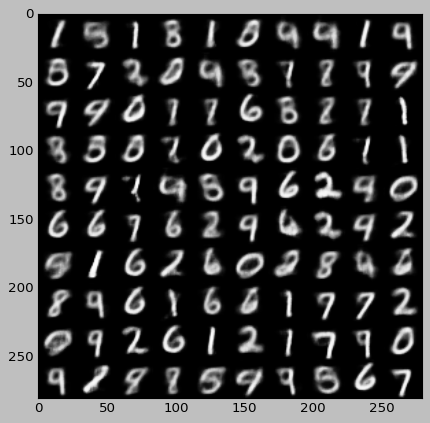

Epoch 3 : Negative log likelihood is 0.037327, mmd loss is 0.009273
Epoch 3 : Negative log likelihood is 0.034070, mmd loss is 0.005850
Epoch 3 : Negative log likelihood is 0.037764, mmd loss is 0.005479


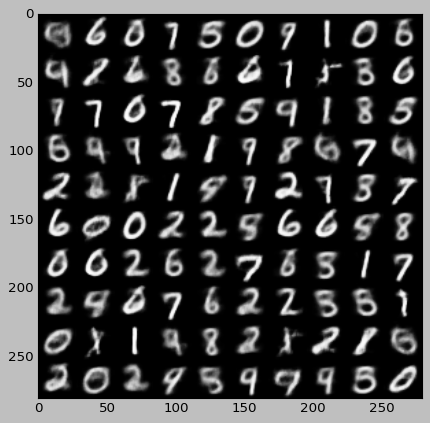

Epoch 4 : Negative log likelihood is 0.034295, mmd loss is 0.003323
Epoch 4 : Negative log likelihood is 0.034709, mmd loss is 0.001855
Epoch 4 : Negative log likelihood is 0.038067, mmd loss is 0.005193


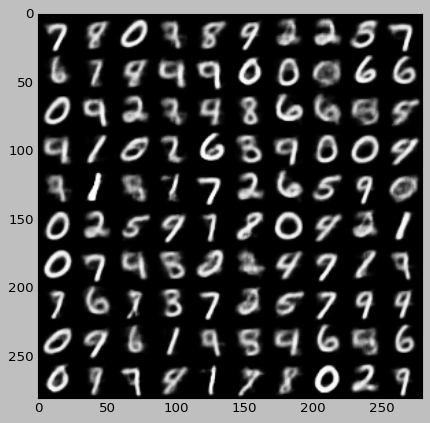

Epoch 5 : Negative log likelihood is 0.034643, mmd loss is 0.007051
Epoch 5 : Negative log likelihood is 0.034809, mmd loss is 0.001387
Epoch 5 : Negative log likelihood is 0.034505, mmd loss is 0.002331


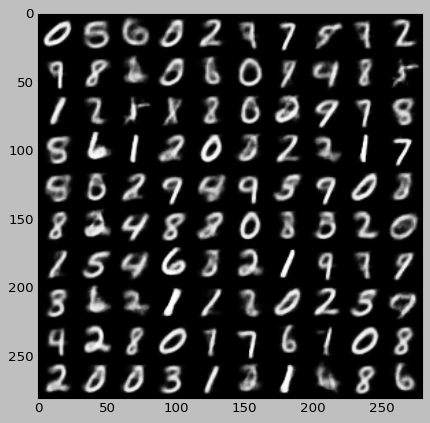

Epoch 6 : Negative log likelihood is 0.033885, mmd loss is 0.001279
Epoch 6 : Negative log likelihood is 0.032258, mmd loss is 0.003972
Epoch 6 : Negative log likelihood is 0.034989, mmd loss is 0.006227


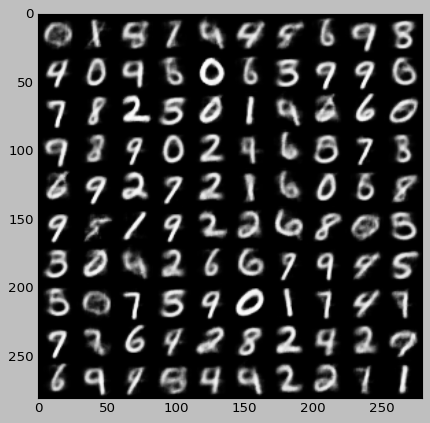

Epoch 7 : Negative log likelihood is 0.034122, mmd loss is 0.013380
Epoch 7 : Negative log likelihood is 0.033300, mmd loss is 0.003791
Epoch 7 : Negative log likelihood is 0.033891, mmd loss is 0.001859


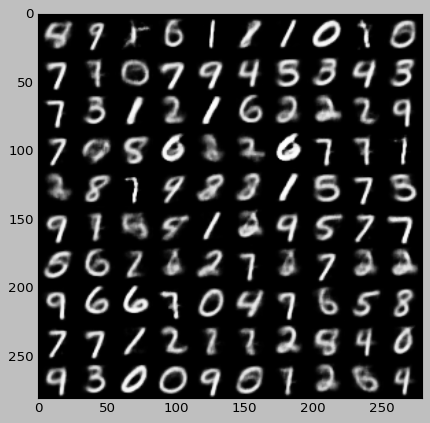

Epoch 8 : Negative log likelihood is 0.032464, mmd loss is 0.001523
Epoch 8 : Negative log likelihood is 0.032986, mmd loss is 0.006972
Epoch 8 : Negative log likelihood is 0.032656, mmd loss is 0.005287


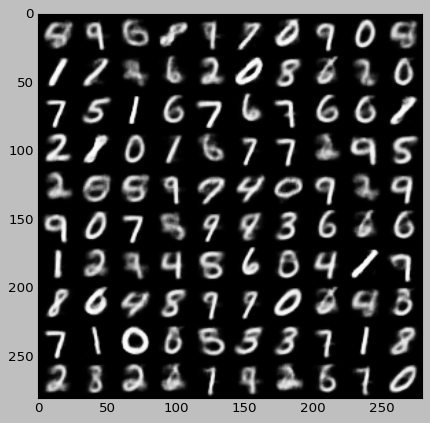

Epoch 9 : Negative log likelihood is 0.032744, mmd loss is 0.004886
Epoch 9 : Negative log likelihood is 0.031212, mmd loss is 0.003023
Epoch 9 : Negative log likelihood is 0.035352, mmd loss is 0.003268


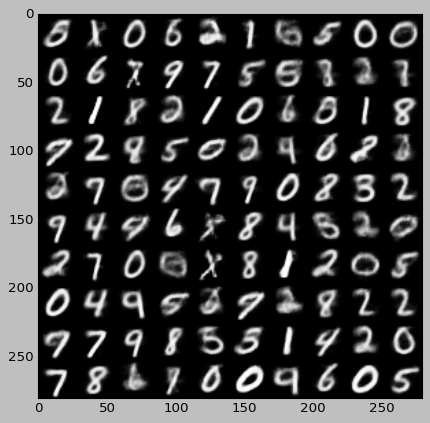

Epoch 10 : Negative log likelihood is 0.031877, mmd loss is 0.003156
Epoch 10 : Negative log likelihood is 0.030205, mmd loss is 0.003861
Epoch 10 : Negative log likelihood is 0.032950, mmd loss is 0.002952


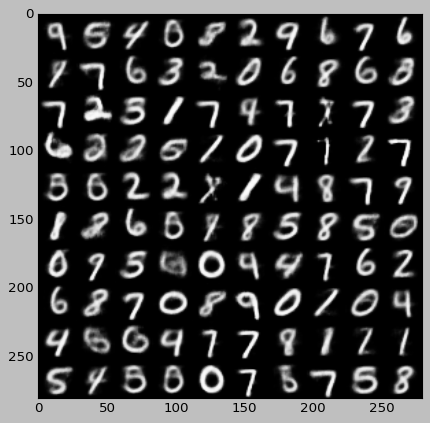

Epoch 11 : Negative log likelihood is 0.032182, mmd loss is 0.004360
Epoch 11 : Negative log likelihood is 0.033432, mmd loss is 0.002751
Epoch 11 : Negative log likelihood is 0.031685, mmd loss is 0.002649


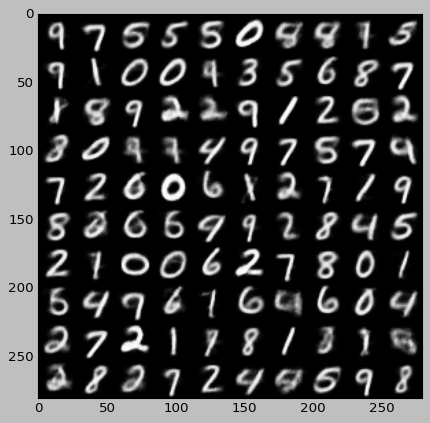

Epoch 12 : Negative log likelihood is 0.032438, mmd loss is 0.010957
Epoch 12 : Negative log likelihood is 0.031724, mmd loss is 0.003422
Epoch 12 : Negative log likelihood is 0.030595, mmd loss is 0.002878


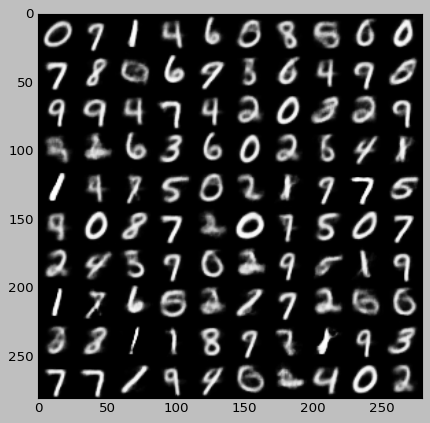

Epoch 13 : Negative log likelihood is 0.031489, mmd loss is 0.004561
Epoch 13 : Negative log likelihood is 0.031920, mmd loss is 0.003867
Epoch 13 : Negative log likelihood is 0.032148, mmd loss is 0.005623


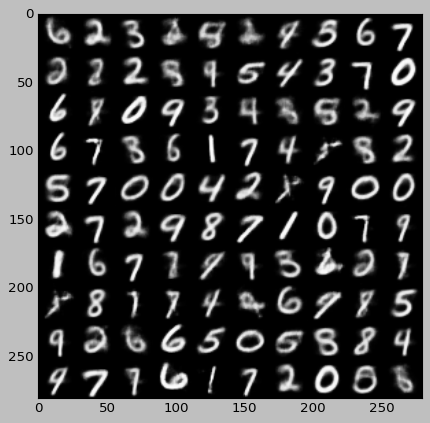

Epoch 14 : Negative log likelihood is 0.030908, mmd loss is 0.005117
Epoch 14 : Negative log likelihood is 0.032456, mmd loss is 0.002531
Epoch 14 : Negative log likelihood is 0.031227, mmd loss is 0.003863


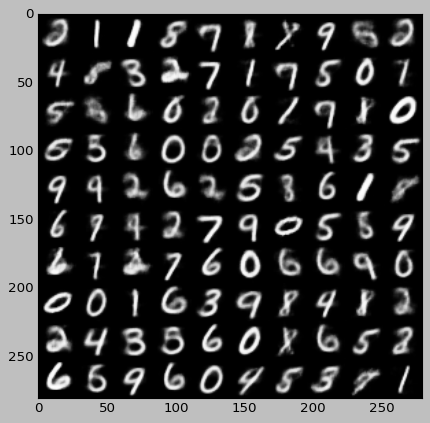

Epoch 15 : Negative log likelihood is 0.032528, mmd loss is 0.002452
Epoch 15 : Negative log likelihood is 0.029517, mmd loss is 0.005499
Epoch 15 : Negative log likelihood is 0.029749, mmd loss is 0.002260


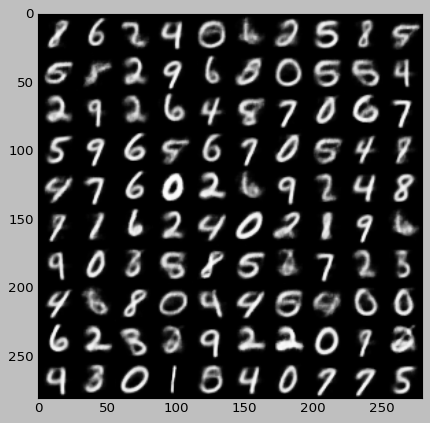

Epoch 16 : Negative log likelihood is 0.030822, mmd loss is 0.009310
Epoch 16 : Negative log likelihood is 0.030436, mmd loss is 0.002831
Epoch 16 : Negative log likelihood is 0.030993, mmd loss is 0.005122


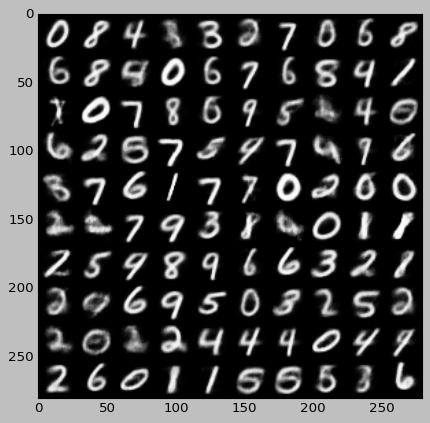

Epoch 17 : Negative log likelihood is 0.030591, mmd loss is 0.002566
Epoch 17 : Negative log likelihood is 0.030583, mmd loss is 0.003065
Epoch 17 : Negative log likelihood is 0.029613, mmd loss is 0.008358


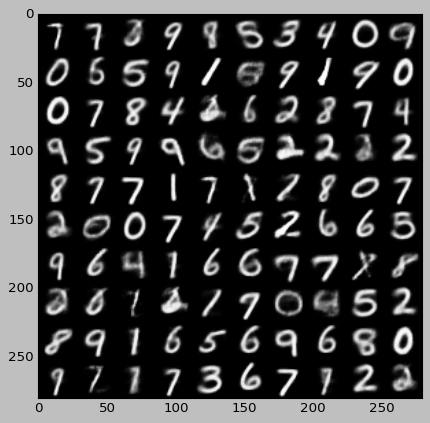

Epoch 18 : Negative log likelihood is 0.031235, mmd loss is 0.005111
Epoch 18 : Negative log likelihood is 0.029413, mmd loss is 0.006233
Epoch 18 : Negative log likelihood is 0.031278, mmd loss is 0.002219


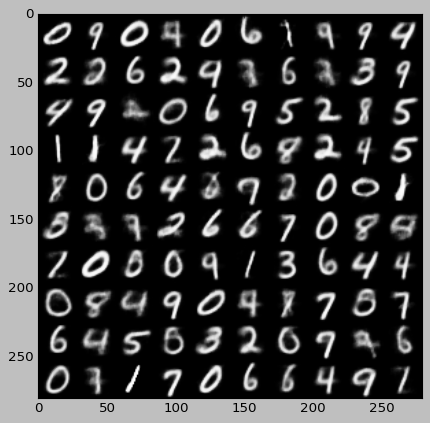

Epoch 19 : Negative log likelihood is 0.031918, mmd loss is 0.005450
Epoch 19 : Negative log likelihood is 0.030961, mmd loss is 0.003065
Epoch 19 : Negative log likelihood is 0.029733, mmd loss is 0.003400


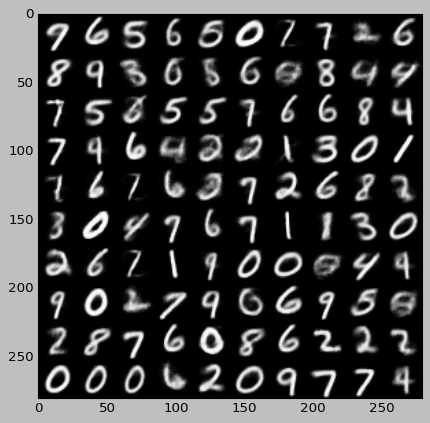

Epoch 20 : Negative log likelihood is 0.028015, mmd loss is 0.001466
Epoch 20 : Negative log likelihood is 0.030255, mmd loss is 0.003737
Epoch 20 : Negative log likelihood is 0.029266, mmd loss is 0.003035


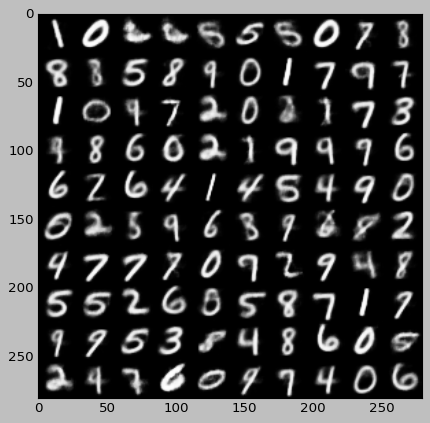

Epoch 21 : Negative log likelihood is 0.031083, mmd loss is 0.009468
Epoch 21 : Negative log likelihood is 0.031218, mmd loss is 0.002236
Epoch 21 : Negative log likelihood is 0.029797, mmd loss is 0.006560


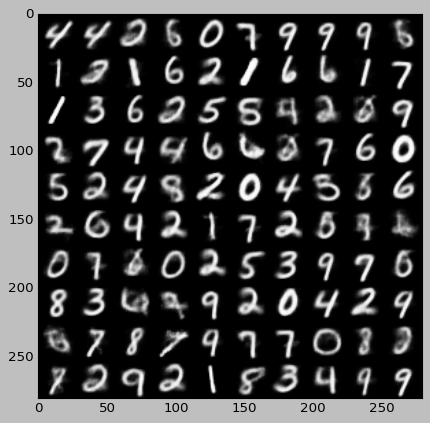

Epoch 22 : Negative log likelihood is 0.028671, mmd loss is 0.006252
Epoch 22 : Negative log likelihood is 0.030344, mmd loss is 0.004368
Epoch 22 : Negative log likelihood is 0.028653, mmd loss is 0.002636


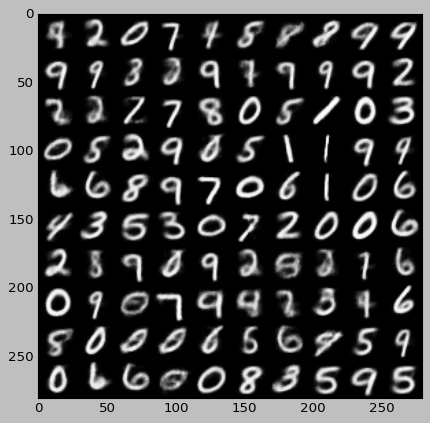

Epoch 23 : Negative log likelihood is 0.033638, mmd loss is 0.004522
Epoch 23 : Negative log likelihood is 0.028810, mmd loss is 0.003659
Epoch 23 : Negative log likelihood is 0.032424, mmd loss is 0.002749


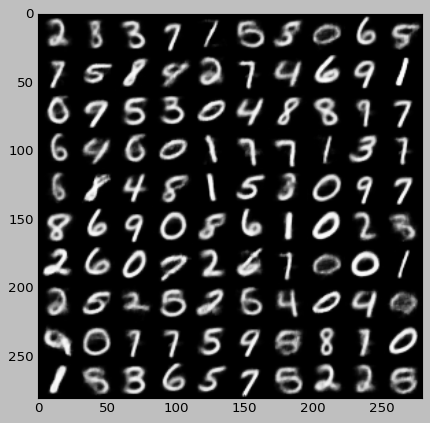

Epoch 24 : Negative log likelihood is 0.028668, mmd loss is 0.003239
Epoch 24 : Negative log likelihood is 0.029925, mmd loss is 0.003361
Epoch 24 : Negative log likelihood is 0.028416, mmd loss is 0.004300


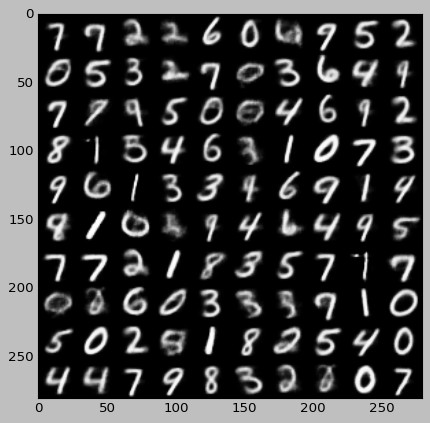

Epoch 25 : Negative log likelihood is 0.029808, mmd loss is 0.006194
Epoch 25 : Negative log likelihood is 0.027472, mmd loss is 0.004197
Epoch 25 : Negative log likelihood is 0.028813, mmd loss is 0.005742


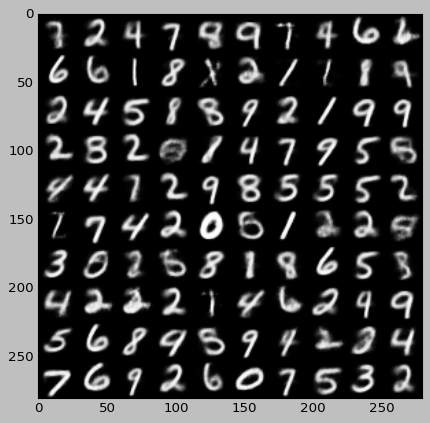

Epoch 26 : Negative log likelihood is 0.029536, mmd loss is 0.003022
Epoch 26 : Negative log likelihood is 0.030040, mmd loss is 0.005664
Epoch 26 : Negative log likelihood is 0.028431, mmd loss is 0.001978


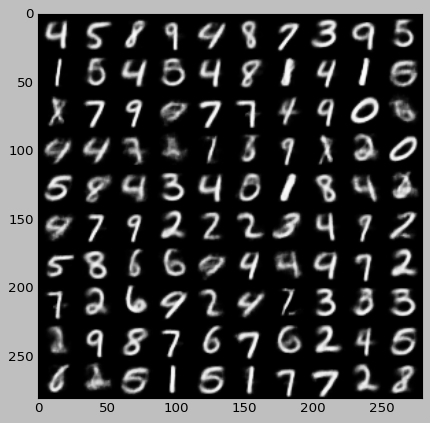

Epoch 27 : Negative log likelihood is 0.030301, mmd loss is 0.002480
Epoch 27 : Negative log likelihood is 0.029833, mmd loss is 0.003279
Epoch 27 : Negative log likelihood is 0.027833, mmd loss is 0.004053


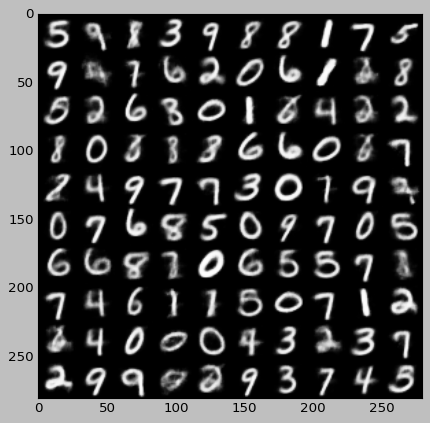

Epoch 28 : Negative log likelihood is 0.028493, mmd loss is 0.002509
Epoch 28 : Negative log likelihood is 0.028581, mmd loss is 0.005672
Epoch 28 : Negative log likelihood is 0.029742, mmd loss is 0.001689


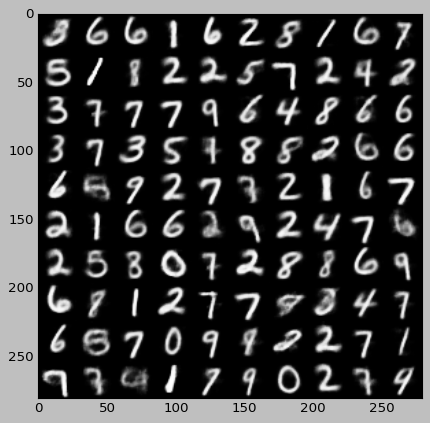

Epoch 29 : Negative log likelihood is 0.028058, mmd loss is 0.003743
Epoch 29 : Negative log likelihood is 0.028942, mmd loss is 0.002241
Epoch 29 : Negative log likelihood is 0.029701, mmd loss is 0.006022


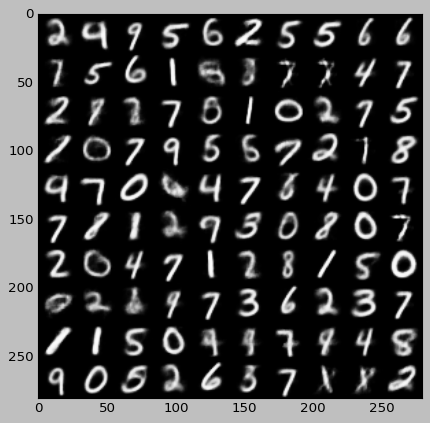

Epoch 30 : Negative log likelihood is 0.027290, mmd loss is 0.009513
Epoch 30 : Negative log likelihood is 0.029335, mmd loss is 0.002891
Epoch 30 : Negative log likelihood is 0.027711, mmd loss is 0.006454


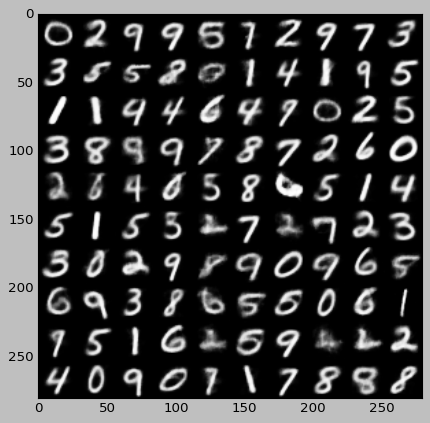

Epoch 31 : Negative log likelihood is 0.029135, mmd loss is 0.004046
Epoch 31 : Negative log likelihood is 0.028444, mmd loss is 0.005842
Epoch 31 : Negative log likelihood is 0.029866, mmd loss is 0.007182


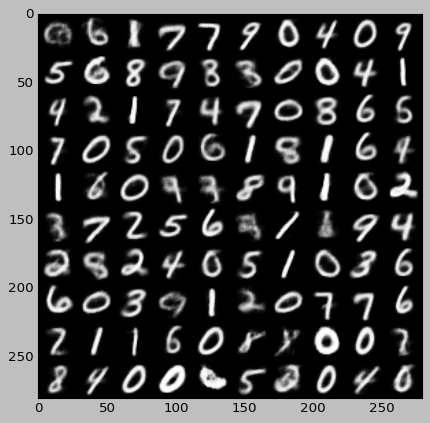

Epoch 32 : Negative log likelihood is 0.028302, mmd loss is 0.002194
Epoch 32 : Negative log likelihood is 0.029696, mmd loss is 0.007650
Epoch 32 : Negative log likelihood is 0.027229, mmd loss is 0.004844


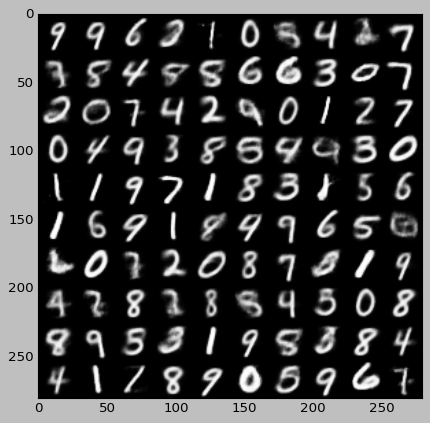

Epoch 33 : Negative log likelihood is 0.028388, mmd loss is 0.009466
Epoch 33 : Negative log likelihood is 0.029588, mmd loss is 0.003116
Epoch 33 : Negative log likelihood is 0.029825, mmd loss is 0.001992


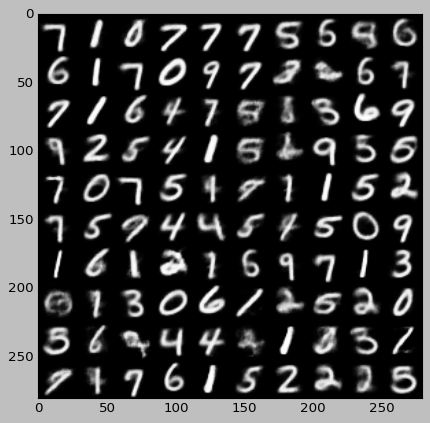

Epoch 34 : Negative log likelihood is 0.029686, mmd loss is 0.002895
Epoch 34 : Negative log likelihood is 0.028094, mmd loss is 0.003792
Epoch 34 : Negative log likelihood is 0.027488, mmd loss is 0.002329


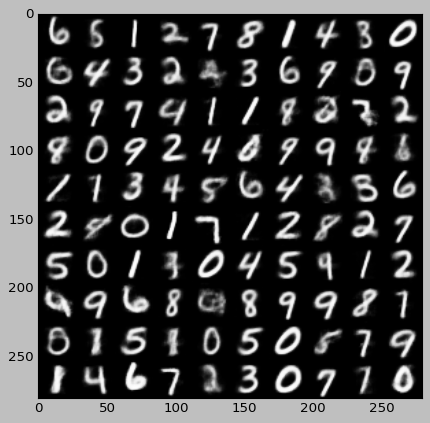

Epoch 35 : Negative log likelihood is 0.028018, mmd loss is 0.002470
Epoch 35 : Negative log likelihood is 0.028353, mmd loss is 0.004187
Epoch 35 : Negative log likelihood is 0.028407, mmd loss is 0.003099


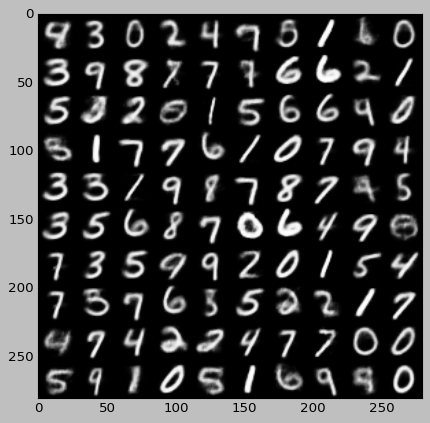

Epoch 36 : Negative log likelihood is 0.032547, mmd loss is 0.006943
Epoch 36 : Negative log likelihood is 0.028101, mmd loss is 0.002410
Epoch 36 : Negative log likelihood is 0.029571, mmd loss is 0.001917


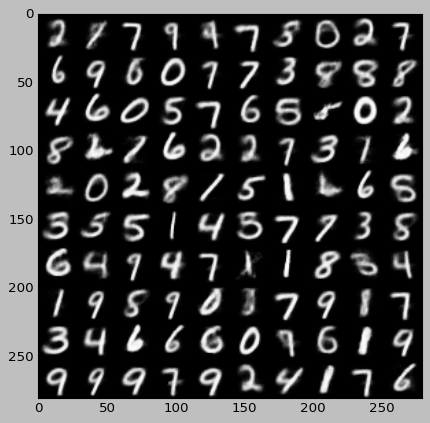

Epoch 37 : Negative log likelihood is 0.027034, mmd loss is 0.011071
Epoch 37 : Negative log likelihood is 0.027915, mmd loss is 0.005340
Epoch 37 : Negative log likelihood is 0.029862, mmd loss is 0.004908


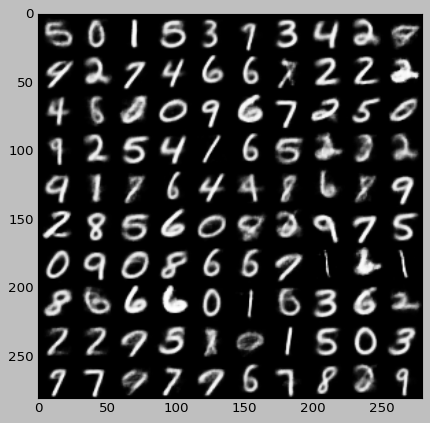

Epoch 38 : Negative log likelihood is 0.028758, mmd loss is 0.003875
Epoch 38 : Negative log likelihood is 0.029176, mmd loss is 0.005354
Epoch 38 : Negative log likelihood is 0.027913, mmd loss is 0.002276


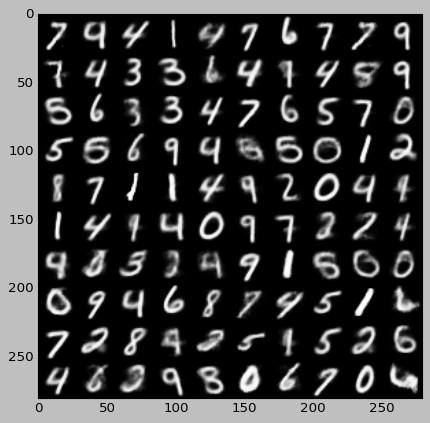

Epoch 39 : Negative log likelihood is 0.028316, mmd loss is 0.002735
Epoch 39 : Negative log likelihood is 0.028770, mmd loss is 0.003253
Epoch 39 : Negative log likelihood is 0.026923, mmd loss is 0.005880


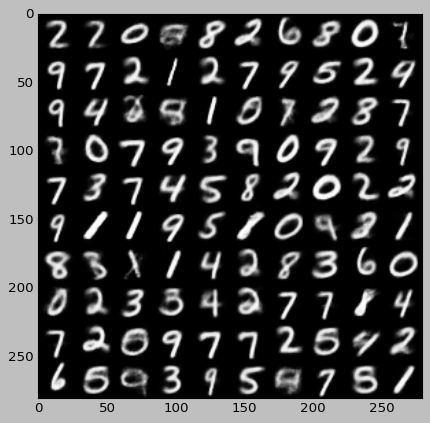

In [15]:
optimizerencoder = optim.Adam(encodermodel.parameters(), lr=1e-3)
optimizerdecoder = optim.Adam(decodermodel.parameters(), lr=1e-3)
for i in range(epochs):

    for batch_idx, (train_x, _) in enumerate(train_loader): 
        train_x= Variable(train_x)
           
        true_samples = torch.randn((len(train_x),z_dim))
        true_samples = Variable(true_samples)
        
        if(usecuda):
            train_x = train_x.cuda(idgpu)
            true_samples = true_samples.cuda(idgpu)
        
        optimizerencoder.zero_grad()
        optimizerdecoder.zero_grad()
        
        train_z = encodermodel(train_x)
        
        train_xr = decodermodel(train_z)
        
        loss_mmd = compute_mmd(true_samples, train_z)
        loss_nll = torch.mean((train_xr - train_x)**2)
        
        loss = loss_nll + loss_mmd
        
        loss.backward()
        
        
        optimizerencoder.step()
        optimizerdecoder.step()
        
        if(batch_idx%100 == 0):
            print("Epoch %d : Negative log likelihood is %f, mmd loss is %f" % (i,loss_nll.data[0], loss_mmd.data[0]))
            
        
    # show images
    gen_z = Variable(torch.randn((100, z_dim)))
    if(usecuda):
        gen_z = gen_z.cuda(idgpu)
    samples = decodermodel(gen_z)
    samples =samples.view(100,28,28,1)
    plt.imshow(convert_to_display(samples.data), cmap='Greys_r')
    plt.show()   
    

In [26]:
# %matplotlib tk

## Scatter Plot after training the VAE

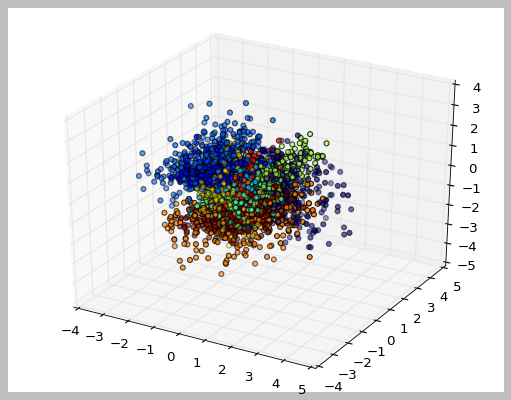

In [27]:
# If latent z is 2-dimensional we visualize it by plotting latent z of different digits in different colors
if z_dim == 3:
    z_list, label_list = [], []
    test_batch_size = 500
    #for i in range(20):
    i = 1
    for batch_idx, (test_x, test_y) in enumerate(test_loader):
        if(i>20):
            break
        test_x= Variable(test_x)
        if(usecuda):
            test_x = test_x.cuda(idgpu)
        z = encodermodel(test_x)   
        z_list.append(z.data.cpu())
        label_list.append(test_y)
        i = i+1
    z = np.concatenate(z_list, axis=0)
    label = np.concatenate(label_list)
#     plt.scatter(z[:, 0], z[:, 1], c=label)
#     plt.show()
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
#     plt.style.use('_classic_test')
    ax.scatter(z[:, 0], z[:, 1],z[:, 2], c=label)
    plt.show()